"""
ÉVALUATION DU MODÈLE DE RECOMMANDATION
======================================

Objectifs :
1. Créer un train/test split
2. Évaluer la performance du modèle
3. Calculer les métriques (RMSE, MAE)
4. Comparer avec un baseline
5. Visualiser les résultats
"""


In [1]:

# Configuration
%matplotlib inline

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')

# Style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Bibliothèques importées")

✅ Bibliothèques importées


In [2]:
print("Chargement des données nettoyées...")

# Charger depuis les fichiers .pkl
df_movies = pd.read_pickle('../models/df_movies_clean.pkl')
df_ratings = pd.read_pickle('../models/df_ratings_clean.pkl')

print(f"✅ {len(df_movies)} films chargés")
print(f"✅ {len(df_ratings)} ratings chargés")
print(f"✅ {df_ratings['userId'].nunique()} utilisateurs")

Chargement des données nettoyées...
✅ 3855 films chargés
✅ 94121 ratings chargés
✅ 668 utilisateurs


In [3]:
print("="*80)
print("📊 CRÉATION DU TRAIN/TEST SPLIT")
print("="*80)

# Pour chaque utilisateur, on garde 20% de ses notes pour le test
train_data = []
test_data = []

for user_id in df_ratings['userId'].unique():
    user_ratings = df_ratings[df_ratings['userId'] == user_id]
    
    # Si l'utilisateur a au moins 5 notes
    if len(user_ratings) >= 5:
        train_user, test_user = train_test_split(
            user_ratings, 
            test_size=0.2, 
            random_state=42
        )
        train_data.append(train_user)
        test_data.append(test_user)
    else:
        # Sinon, tout va dans le train
        train_data.append(user_ratings)

train_df = pd.concat(train_data, ignore_index=True)
test_df = pd.concat(test_data, ignore_index=True)

print(f"\n📊 Train set : {len(train_df)} ratings ({len(train_df)/len(df_ratings)*100:.1f}%)")
print(f"📊 Test set  : {len(test_df)} ratings ({len(test_df)/len(df_ratings)*100:.1f}%)")
print(f"\n✅ Split terminé")

📊 CRÉATION DU TRAIN/TEST SPLIT

📊 Train set : 75042 ratings (79.7%)
📊 Test set  : 19079 ratings (20.3%)

✅ Split terminé


In [4]:
print("Création de la matrice utilisateur-film avec les données d'entraînement...")

train_matrix = train_df.pivot_table(
    index='userId',
    columns='movieId',
    values='rating',
    fill_value=0
)

print(f"✅ Matrice d'entraînement : {train_matrix.shape}")
print(f"   - {train_matrix.shape[0]} utilisateurs")
print(f"   - {train_matrix.shape[1]} films")
print(f"   - Densité : {(train_matrix > 0).sum().sum() / (train_matrix.shape[0] * train_matrix.shape[1]) * 100:.2f}%")

Création de la matrice utilisateur-film avec les données d'entraînement...
✅ Matrice d'entraînement : (668, 3855)
   - 668 utilisateurs
   - 3855 films
   - Densité : 2.91%


In [5]:
def predict_rating(user_id, movie_id, train_matrix, k=20):
    """
    Prédit la note qu'un utilisateur donnerait à un film
    
    Args:
        user_id: ID de l'utilisateur
        movie_id: ID du film
        train_matrix: Matrice d'entraînement
        k: Nombre de voisins similaires
    
    Returns:
        Note prédite (float)
    """
    # Si l'utilisateur n'existe pas, retourner la moyenne globale
    if user_id not in train_matrix.index:
        return df_ratings['rating'].mean()
    
    # Si le film n'existe pas, retourner la moyenne globale
    if movie_id not in train_matrix.columns:
        return df_ratings['rating'].mean()
    
    # Obtenir le vecteur de l'utilisateur
    user_vector = train_matrix.loc[user_id].values.reshape(1, -1)
    
    # Calculer similarité avec tous les autres utilisateurs
    similarities = cosine_similarity(user_vector, train_matrix.values)[0]
    
    # Trouver les k utilisateurs les plus similaires (exclure l'utilisateur lui-même)
    similar_users_idx = np.argsort(similarities)[::-1][1:k+1]
    
    # Obtenir leurs notes pour ce film
    similar_ratings = train_matrix.iloc[similar_users_idx][movie_id]
    similar_weights = similarities[similar_users_idx]
    
    # Filtrer ceux qui n'ont pas noté ce film
    mask = similar_ratings > 0
    similar_ratings = similar_ratings[mask]
    similar_weights = similar_weights[mask]
    
    # Si personne n'a noté ce film, retourner la moyenne
    if len(similar_ratings) == 0:
        return df_ratings['rating'].mean()
    
    # Calculer la prédiction pondérée
    prediction = np.dot(similar_ratings, similar_weights) / similar_weights.sum()
    
    # Limiter entre 0.5 et 5.0
    return np.clip(prediction, 0.5, 5.0)

print("✅ Fonction de prédiction créée")

✅ Fonction de prédiction créée


In [8]:
print("="*80)
print("🧪 ÉVALUATION SUR LE TRAIN SET (pour détecter l'overfitting)")
print("="*80)
print("⏳ Évaluation en cours (1000 prédictions sur train)...\n")

train_predictions = []
train_actuals = []

# Limiter à 1000 prédictions pour la vitesse
train_sample = train_df.sample(min(1000, len(train_df)), random_state=42)

for idx, row in train_sample.iterrows():
    user_id = row['userId']
    movie_id = row['movieId']
    actual_rating = row['rating']
    
    # Prédire
    predicted_rating = predict_rating(user_id, movie_id, train_matrix, k=20)
    
    train_predictions.append(predicted_rating)
    train_actuals.append(actual_rating)
    
    # Afficher la progression
    if (len(train_predictions)) % 100 == 0:
        print(f"  ✓ {len(train_predictions)}/1000 prédictions")

train_predictions = np.array(train_predictions)
train_actuals = np.array(train_actuals)

print(f"\n✅ {len(train_predictions)} prédictions sur train terminées")

🧪 ÉVALUATION SUR LE TRAIN SET (pour détecter l'overfitting)
⏳ Évaluation en cours (1000 prédictions sur train)...

  ✓ 100/1000 prédictions
  ✓ 200/1000 prédictions
  ✓ 300/1000 prédictions
  ✓ 400/1000 prédictions
  ✓ 500/1000 prédictions
  ✓ 600/1000 prédictions
  ✓ 700/1000 prédictions
  ✓ 800/1000 prédictions
  ✓ 900/1000 prédictions
  ✓ 1000/1000 prédictions

✅ 1000 prédictions sur train terminées


In [6]:
print("="*80)
print("🧪 ÉVALUATION DU MODÈLE SUR LE TEST SET")
print("="*80)
print("⏳ Évaluation en cours (1000 prédictions)...\n")

predictions = []
actuals = []

# Limiter à 1000 prédictions pour la vitesse
test_sample = test_df.sample(min(1000, len(test_df)), random_state=42)

for idx, row in test_sample.iterrows():
    user_id = row['userId']
    movie_id = row['movieId']
    actual_rating = row['rating']
    
    # Prédire
    predicted_rating = predict_rating(user_id, movie_id, train_matrix, k=20)
    
    predictions.append(predicted_rating)
    actuals.append(actual_rating)
    
    # Afficher la progression
    if (len(predictions)) % 100 == 0:
        print(f"  ✓ {len(predictions)}/1000 prédictions")

predictions = np.array(predictions)
actuals = np.array(actuals)

print(f"\n✅ {len(predictions)} prédictions terminées")

🧪 ÉVALUATION DU MODÈLE SUR LE TEST SET
⏳ Évaluation en cours (1000 prédictions)...

  ✓ 100/1000 prédictions
  ✓ 200/1000 prédictions
  ✓ 300/1000 prédictions
  ✓ 400/1000 prédictions
  ✓ 500/1000 prédictions
  ✓ 600/1000 prédictions
  ✓ 700/1000 prédictions
  ✓ 800/1000 prédictions
  ✓ 900/1000 prédictions
  ✓ 1000/1000 prédictions

✅ 1000 prédictions terminées


In [11]:
print("="*80)
print("📈 RÉSULTATS DE L'ÉVALUATION COMPLÈTE")
print("="*80)

# Métriques sur TRAIN
rmse_train = np.sqrt(mean_squared_error(train_actuals, train_predictions))
mae_train = mean_absolute_error(train_actuals, train_predictions)

# Métriques sur TEST
rmse_test = np.sqrt(mean_squared_error(actuals, predictions))
mae_test = mean_absolute_error(actuals, predictions)

# Baseline
baseline_pred_test = np.full(len(actuals), df_ratings['rating'].mean())
rmse_baseline = np.sqrt(mean_squared_error(actuals, baseline_pred_test))
mae_baseline = mean_absolute_error(actuals, baseline_pred_test)

print(f"\n🎯 TRAIN SET (ce que le modèle a vu) :")
print(f"   RMSE : {rmse_train:.4f}")
print(f"   MAE  : {mae_train:.4f}")

print(f"\n🧪 TEST SET (données jamais vues) :")
print(f"   RMSE : {rmse_test:.4f}")
print(f"   MAE  : {mae_test:.4f}")

print(f"\n📌 BASELINE (prédire la moyenne = {df_ratings['rating'].mean():.2f}) :")
print(f"   RMSE : {rmse_baseline:.4f}")
print(f"   MAE  : {mae_baseline:.4f}")

print(f"\n🔍 DIFFÉRENCE TRAIN vs TEST :")
diff_rmse = ((rmse_test - rmse_train) / rmse_train) * 100
diff_mae = ((mae_test - mae_train) / mae_train) * 100
print(f"   RMSE : {diff_rmse:+.1f}%")
print(f"   MAE  : {diff_mae:+.1f}%")

print(f"\n📊 AMÉLIORATION vs BASELINE :")
improvement_rmse = ((rmse_baseline - rmse_test) / rmse_baseline) * 100
improvement_mae = ((mae_baseline - mae_test) / mae_baseline) * 100
print(f"   RMSE : {improvement_rmse:.1f}% {'meilleur' if improvement_rmse > 0 else 'moins bon'}")
print(f"   MAE  : {improvement_mae:.1f}% {'meilleur' if improvement_mae > 0 else 'moins bon'}")

print("\n" + "="*80)

📈 RÉSULTATS DE L'ÉVALUATION COMPLÈTE

🎯 TRAIN SET (ce que le modèle a vu) :
   RMSE : 0.9892
   MAE  : 0.7621

🧪 TEST SET (données jamais vues) :
   RMSE : 1.0344
   MAE  : 0.8142

📌 BASELINE (prédire la moyenne = 3.57) :
   RMSE : 1.0320
   MAE  : 0.8322

🔍 DIFFÉRENCE TRAIN vs TEST :
   RMSE : +4.6%
   MAE  : +6.8%

📊 AMÉLIORATION vs BASELINE :
   RMSE : -0.2% moins bon
   MAE  : 2.2% meilleur



✅ Graphique sauvegardé : train_test_comparison.png


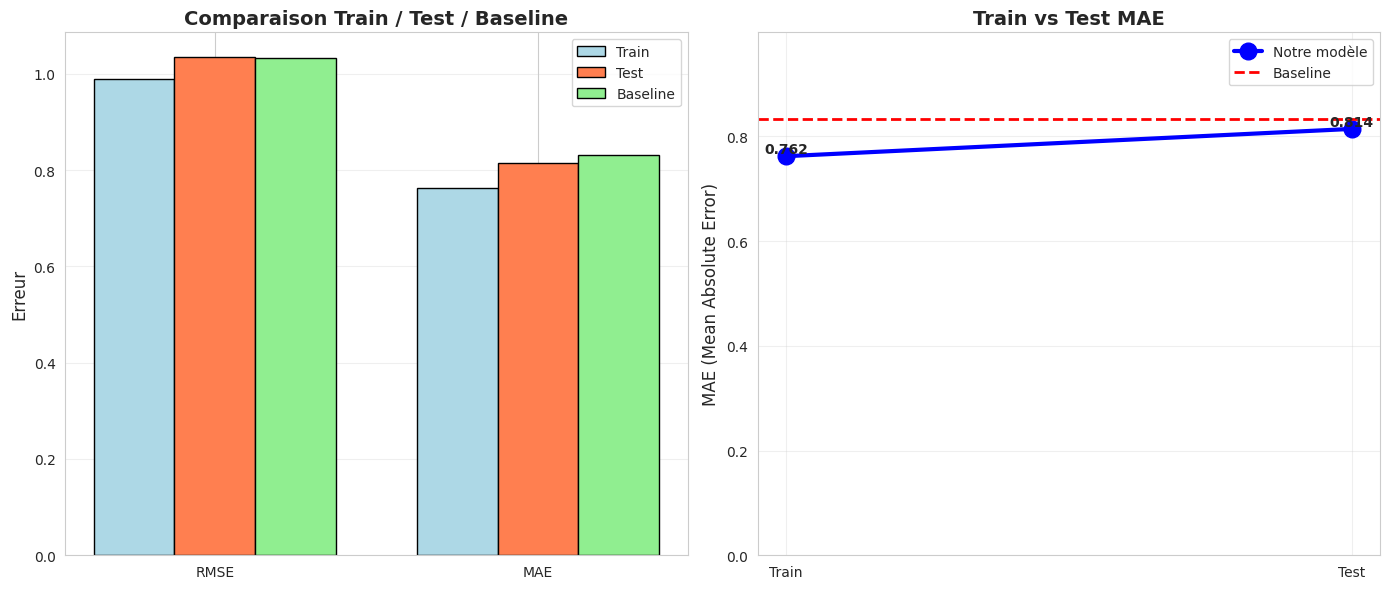

In [12]:
# Graphique Train vs Test
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Subplot 1 : Comparaison des métriques
metrics_data = {
    'Train': [rmse_train, mae_train],
    'Test': [rmse_test, mae_test],
    'Baseline': [rmse_baseline, mae_baseline]
}

x = np.arange(2)
width = 0.25

colors = ['lightblue', 'coral', 'lightgreen']
for i, (label, values) in enumerate(metrics_data.items()):
    offset = width * (i - 1)
    axes[0].bar(x + offset, values, width, label=label, color=colors[i], edgecolor='black')

axes[0].set_ylabel('Erreur', fontsize=12)
axes[0].set_title('Comparaison Train / Test / Baseline', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(['RMSE', 'MAE'])
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Subplot 2 : Train vs Test Error
axes[1].plot(['Train', 'Test'], [mae_train, mae_test], 
             marker='o', markersize=12, linewidth=3, color='blue', label='Notre modèle')
axes[1].axhline(y=mae_baseline, color='red', linestyle='--', 
                linewidth=2, label='Baseline')
axes[1].set_ylabel('MAE (Mean Absolute Error)', fontsize=12)
axes[1].set_title('Train vs Test MAE', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)
axes[1].set_ylim(0, max(mae_train, mae_test, mae_baseline) * 1.2)

# Annoter les valeurs
axes[1].text(0, mae_train, f'{mae_train:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
axes[1].text(1, mae_test, f'{mae_test:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('train_test_comparison.png', dpi=150, bbox_inches='tight')
print("✅ Graphique sauvegardé : train_test_comparison.png")
plt.show()